# Neural Networks: Learning Techniques and Natural Language Processing

**Исполнители (ФИО):** Your answer here

---

Здравствуйте, подходит к концу курс Машинного Обучения

В рамках изучения нейронных сетей существует огромное количество тем и задач, однако охватить все и сразу невозможно

Поэтому в этом блокноте вы познакомитесь со способами улучшения сходимости нейросетей и борьба с переобучением, а также задачей обработки естественного языка

`В данном блокноте вы будете работать с библиотекой PyTorch, для комфортной работы и чтобы не тратить время на установку, воспользуйтесь сервисом Google Collab, в котором этот инструмент уже предустановлен`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


Как улучшить сходимость нейронной сети? Казалось бы, добавим много скрытых слоев. Да, модель будет дольше учиться, зато выучит больше признаков и результат станет лучше. Однако, как вы могли заметить в предыдущем блокноте, этого не происходит. Причиной этому служит [затухание/взрыв градиента](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D1%8B_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9)

Поскольку для вычисления градиента функции потерь необходимо последовательно перемножать производные, то градиент может уменьшаться/расти экспоненциально, если множители в нашем произведении будут слишком маленькими/большими

Для решения этой проблемы существует несколько способов, которые можно сочетать:
1. Нормализация данных
2. Инициализация весов
3. Нормализация выходов нейронов (Batch Normalization)
4. Регуляризация (L1, L2, Dropout)

Помимо L1, L2 регуляризации, существует так называемый Dropout подход. Суть его заключается в том, чтобы выключать(занулять) случайную долю выходов нейронов, чтобы блокировать обновление весов

## Задача 1

Загрузите датасет *CIFAR10*

Этот датасет содержит картинки размера 32 x 32 реальных объектов, представленных 10 классами: самолеты, машины, птицы, олени, кошки, собаки, лягушки, лошади, корабли и грузовики

In [2]:
# Нормализация для CIFAR-10 (стандартные mean/std по каналам)
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2023, 0.1994, 0.2010)

train_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

batch_size = 1024
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,num_workers=0)

classes = train_ds.classes
print("classes:", classes)
print("train size:", len(train_ds), "test size:", len(test_ds))

# sanity check: один батч
x, y = next(iter(train_loader))
print("batch x:", x.shape, x.dtype, "batch y:", y.shape, y.dtype, "device:", device)

100%|██████████| 170M/170M [00:28<00:00, 5.88MB/s] 


classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train size: 50000 test size: 10000
batch x: torch.Size([1024, 3, 32, 32]) torch.float32 batch y: torch.Size([1024]) torch.int64 device: mps


Слой нормализации выходов нейронов представлен классом *nn.BatchNorm1d*

Слой случайного выключения связей между нейронами представлен классом *nn.Dropout1d* 

Опишите базовую архитектуру глубокой нейронной сети для решения задачи классификации на этом датасете. Можете использовать любые слои из *torch.nn*, кроме *BatchNorm* и *Dropout*-подобных. Добавьте по меньшей мере 7 скрытых слоев с обучаемыми параметрами

In [3]:
class DeepCIFARNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        def conv3x3(cin, cout):
            return nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=True)

        self.features = nn.Sequential(
            # 32x32
            conv3x3(3, 64), nn.ReLU(),
            conv3x3(64, 64), nn.ReLU(),
            nn.MaxPool2d(2),              # 16x16

            conv3x3(64, 128), nn.ReLU(),
            conv3x3(128, 128), nn.ReLU(),
            nn.MaxPool2d(2),              # 8x8

            conv3x3(128, 256), nn.ReLU(),
            conv3x3(256, 256), nn.ReLU(),
            nn.MaxPool2d(2),              # 4x4

            conv3x3(256, 512), nn.ReLU(),
            conv3x3(512, 512), nn.ReLU(), # 4x4
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # -> 512x1x1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, n_classes)  # logits
        )

        self._init_weights()

    def _init_weights(self):
        # Kaiming init под ReLU
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

**Вопрос:** Обоснуйте выбор архитектуры нейронной сети. Какие слои использовали и почему?

Мы используем последовательности свёрток 3×3 (VGG-подобный подход): стек маленьких свёрток увеличивает эффективное поле зрения и позволяет строить более глубокую модель. 

По сравнению с большими ядрами (например, 5×5) это даёт меньше параметров при сопоставимом receptive field и добавляет больше нелинейностей, что обычно улучшает качество извлечения признаков.

Но просто увеличивая количество слоёв мы скорее всего придём в переобучение

Сделайте ещё три нейросети, в двух из которых используете по отдельности BatchNorm в каждом скрытом слое, а Dropout в нескольких последних слоях. А в третьей объедините этих два подхода

In [4]:

# штука шоб блоки строить(так интереснее, чем копипаста)
def conv3x3(cin, cout, bias=True):
    return nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=bias)

class DeepCIFAR_BN(nn.Module):
    """
    BatchNorm в каждом скрытом слое (Conv -> BN -> ReLU).
    """
    def __init__(self, n_classes=10):
        super().__init__()

        # если Conv сразу перед BN, bias не нужен (BN "съедает" сдвиг) 
        def CBR(cin, cout):
            return nn.Sequential(
                conv3x3(cin, cout, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU()
            )

        self.features = nn.Sequential(
            CBR(3, 64),  CBR(64, 64),  nn.MaxPool2d(2),      # 16x16
            CBR(64, 128), CBR(128, 128), nn.MaxPool2d(2),    # 8x8
            CBR(128, 256), CBR(256, 256), nn.MaxPool2d(2),   # 4x4
            CBR(256, 512), CBR(512, 512),                    # 4x4
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


class DeepCIFAR_Dropout(nn.Module):
    """
    Без BatchNorm.
    Dropout в нескольких последних слоях 
    """
    def __init__(self, n_classes=10, p2d=0.2, p=0.5):
        super().__init__()

        def CR(cin, cout):
            return nn.Sequential(
                conv3x3(cin, cout, bias=True),
                nn.ReLU()
            )

        self.features = nn.Sequential(
            CR(3, 64),  CR(64, 64),  nn.MaxPool2d(2),            # 16x16
            CR(64, 128), CR(128, 128), nn.MaxPool2d(2),          # 8x8
            CR(128, 256), CR(256, 256), nn.MaxPool2d(2),         # 4x4

            # "несколько последних слоёв" регуляризируем сильнее
            CR(256, 512),
            nn.Dropout2d(p=p2d),
            CR(512, 512),
            nn.Dropout2d(p=p2d),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


class DeepCIFAR_BN_Dropout(nn.Module):
    """
    BatchNorm в каждом скрытом слое + Dropout ближе к выходу.
    Важно: Dropout не ставим перед BN; типовой порядок:
    Conv/FC -> BN -> ReLU -> Dropout  
    """
    def __init__(self, n_classes=10, p2d=0.15, p=0.4):
        super().__init__()

        def CBR(cin, cout):
            return nn.Sequential(
                conv3x3(cin, cout, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU()
            )

        self.features = nn.Sequential(
            CBR(3, 64),  CBR(64, 64),  nn.MaxPool2d(2),
            CBR(64, 128), CBR(128, 128), nn.MaxPool2d(2),
            CBR(128, 256), CBR(256, 256), nn.MaxPool2d(2),

            # dropout в последних conv-блоках
            CBR(256, 512),
            nn.Dropout2d(p=p2d),
            CBR(512, 512),
            nn.Dropout2d(p=p2d),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

Обучите все четыре нейросети решать задачу классификации картинок, по желанию используйте L1, L2 регуляризацию

In [5]:
def run_epoch(model, loader, criterion, optimizer=None, l1_lambda=0.0):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=False)
        y = y.to(device, non_blocking=False)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = criterion(logits, y)

            # L1 (опционально)
            if l1_lambda > 0:
                l1 = 0.0
                for p in model.parameters():
                    l1 = l1 + p.abs().sum()
                loss = loss + l1_lambda * l1

            if is_train:
                loss.backward()
                optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += bs

    return total_loss / total, correct / total


def fit(model, train_loader, test_loader, epochs, optimizer, criterion, l1_lambda=0.0):
    hist = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    for epoch in range(epochs):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer=optimizer, l1_lambda=l1_lambda)
        te_loss, te_acc = run_epoch(model, test_loader,  criterion, optimizer=None)

        hist["train_loss"].append(tr_loss)
        hist["test_loss"].append(te_loss)
        hist["train_acc"].append(tr_acc)
        hist["test_acc"].append(te_acc)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
                  f"test  loss {te_loss:.4f} acc {te_acc:.3f}")
    return hist

In [6]:
criterion = torch.nn.CrossEntropyLoss().to(device)

# L2 пример:
wd = 1e-4  # L2/weight decay
# AdamW обычно предпочтительнее обычного Adam с weight_decay
def make_optim(model):
    return torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=wd)

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

@torch.no_grad()
def collect_probs(model, loader, n_classes=10):
    model.eval()
    ys = []
    ps = []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1)          # (B, C)
        ys.append(y.cpu().numpy())
        ps.append(probs.cpu().numpy())
    y_true = np.concatenate(ys, axis=0)               # (N,)
    y_score = np.concatenate(ps, axis=0)              # (N, C)
    assert y_score.shape[1] == n_classes
    return y_true, y_score


def plot_multiclass_roc(y_true, y_score, class_names=None, title="Multiclass ROC (OvR)"):
    n_classes = y_score.shape[1]
    if class_names is None:
        class_names = [f"class {i}" for i in range(n_classes)]

    # binarize y: (N,) -> (N,C) one-vs-rest targets
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # AUC summary (macro/micro) через sklearn
    auc_macro = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
    auc_micro = roc_auc_score(y_true, y_score, multi_class="ovr", average="micro")

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average ROC curve: flatten all classes
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro-average ROC curve: interpolate mean TPR over a common FPR grid
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro ROC (AUC={roc_auc['micro']:.3f})")
    plt.plot(fpr["macro"], tpr["macro"], label=f"macro ROC (AUC={roc_auc['macro']:.3f})")

    # per-class (можно закомментить, если график становится кашей)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], alpha=0.5, label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{title}\nAUC macro={auc_macro:.3f}, micro={auc_micro:.3f}")
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.show()

    return {"auc_macro": auc_macro, "auc_micro": auc_micro, "auc_per_class": roc_auc}

In [10]:
epochs = 30  # для CIFAR-10 это “быстро проверить”; для качества обычно надо больше, но даже это обучалось час....

models = {
    "baseline": DeepCIFARNet(n_classes=10).to(device),
    "BN":       DeepCIFAR_BN(n_classes=10).to(device),
    "Dropout":  DeepCIFAR_Dropout(n_classes=10, p2d=0.2, p=0.5).to(device),
    "BN+DO":    DeepCIFAR_BN_Dropout(n_classes=10, p2d=0.15, p=0.4).to(device),
}

histories = {}

for name, model in models.items():
    print(f"\n=== Training: {name} ===")
    optim = make_optim(model)
    histories[name] = fit(model, train_loader, test_loader, epochs, optim, criterion, l1_lambda=0.0)


=== Training: baseline ===
Epoch 5/30 | train loss 1.1865 acc 0.571 | test  loss 1.1073 acc 0.602
Epoch 10/30 | train loss 0.6212 acc 0.780 | test  loss 0.8164 acc 0.728
Epoch 15/30 | train loss 0.3252 acc 0.886 | test  loss 0.8444 acc 0.744
Epoch 20/30 | train loss 0.0808 acc 0.972 | test  loss 1.3366 acc 0.730
Epoch 25/30 | train loss 0.0449 acc 0.985 | test  loss 1.4642 acc 0.746
Epoch 30/30 | train loss 0.0066 acc 0.998 | test  loss 1.7677 acc 0.766

=== Training: BN ===
Epoch 5/30 | train loss 0.4670 acc 0.839 | test  loss 0.8226 acc 0.741
Epoch 10/30 | train loss 0.1432 acc 0.952 | test  loss 0.7936 acc 0.793
Epoch 15/30 | train loss 0.0463 acc 0.984 | test  loss 1.1829 acc 0.781
Epoch 20/30 | train loss 0.0277 acc 0.990 | test  loss 1.0808 acc 0.804
Epoch 25/30 | train loss 0.0222 acc 0.992 | test  loss 1.0976 acc 0.811
Epoch 30/30 | train loss 0.0228 acc 0.993 | test  loss 1.0636 acc 0.818

=== Training: Dropout ===
Epoch 5/30 | train loss 1.2804 acc 0.528 | test  loss 1.2339 

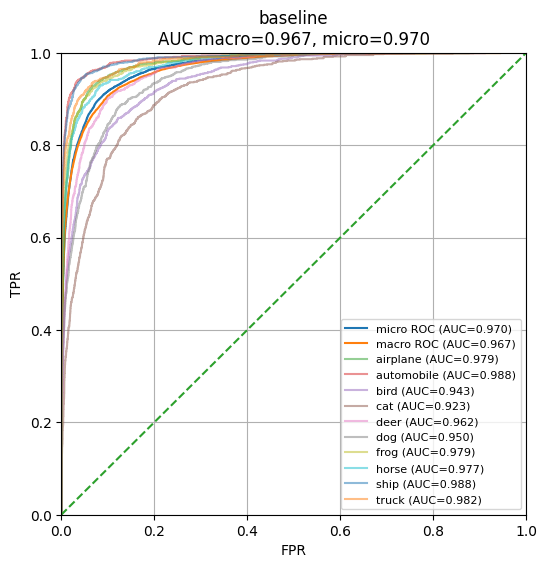

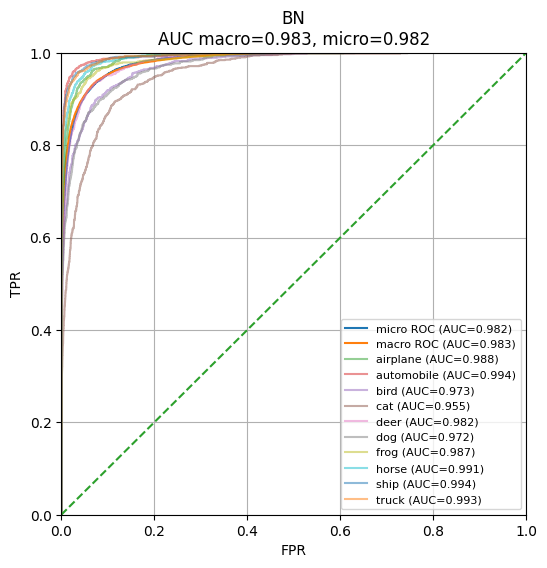

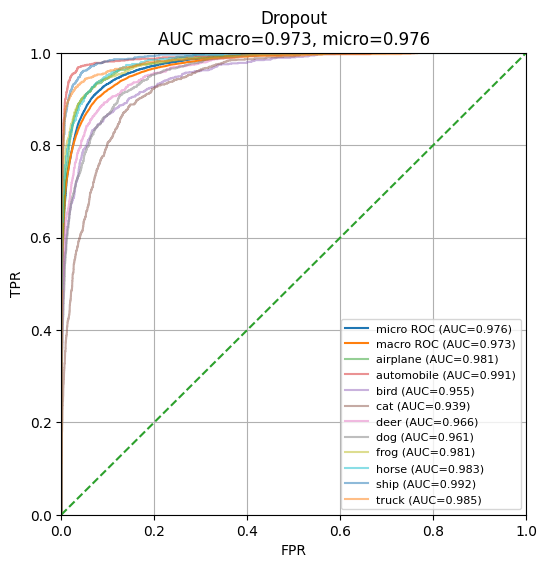

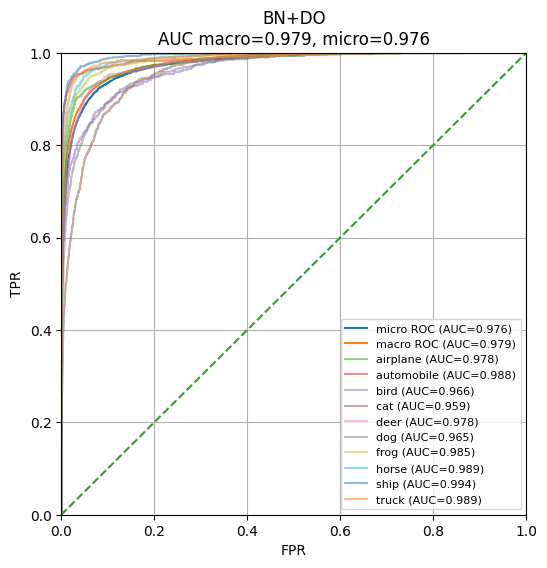

AUC (macro, micro):
baseline: 0.9671, 0.9697
BN      : 0.9830, 0.9825
Dropout : 0.9733, 0.9760
BN+DO   : 0.9791, 0.9760


In [11]:

auc_summary = {}

for name, model in models.items():
    y_true, y_score = collect_probs(model, test_loader, n_classes=10)

    auc_macro = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
    auc_micro = roc_auc_score(y_true, y_score, multi_class="ovr", average="micro")

    auc_summary[name] = (auc_macro, auc_micro)

    plot_multiclass_roc(y_true, y_score, class_names=classes, title=name)

print("AUC (macro, micro):")
for name, (am, ai) in auc_summary.items():
    print(f"{name:8s}: {am:.4f}, {ai:.4f}")

Сравните все 4 классификатора между собой по качеству и скорости обучения. Постройте графики обучения моделей и ROC кривые

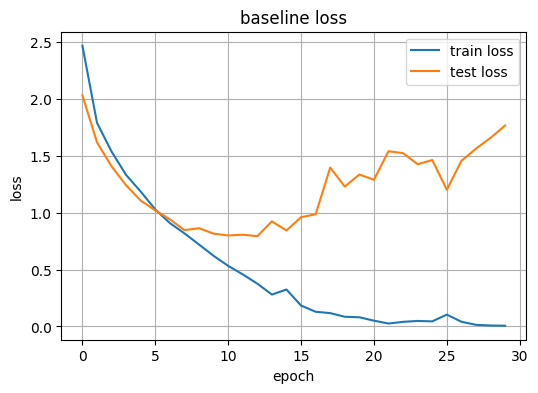

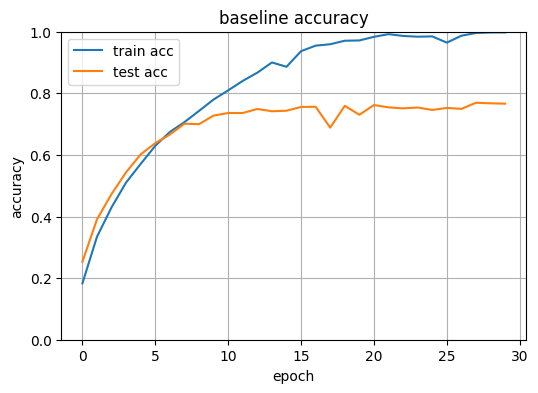

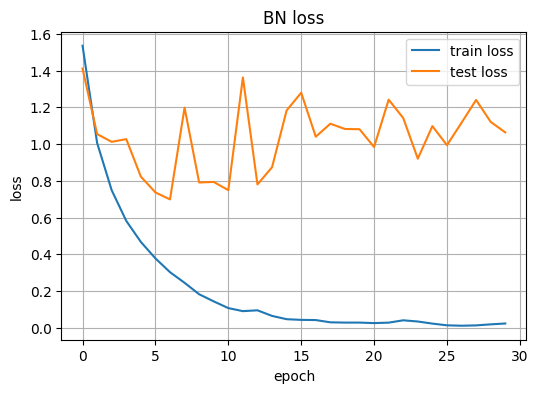

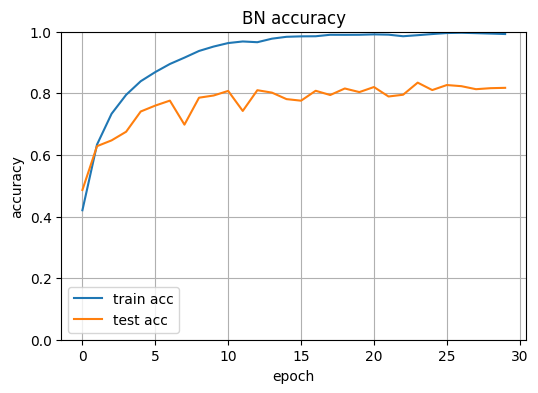

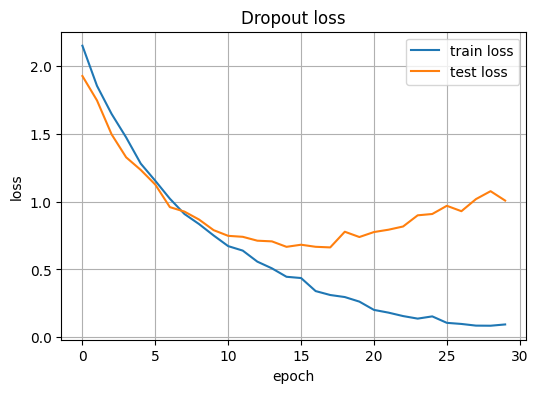

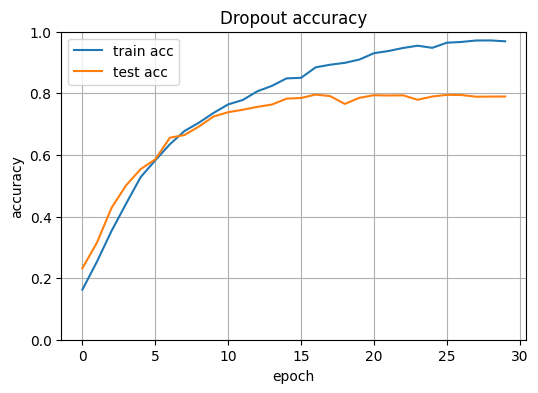

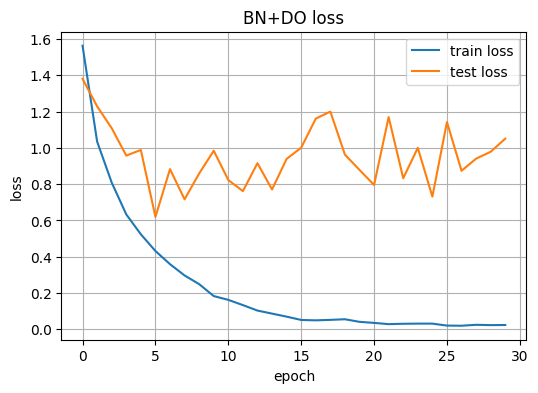

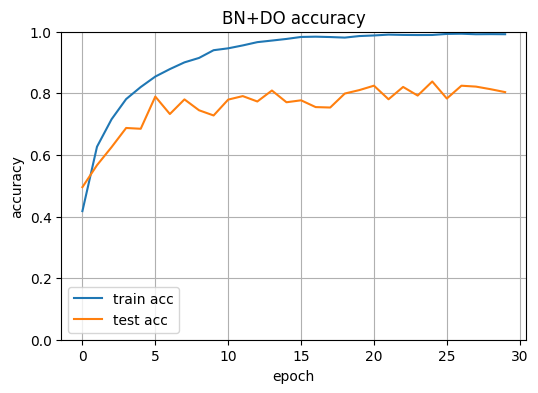

In [12]:
def plot_hist(hist, title_prefix=""):
    plt.figure(figsize=(6,4))
    plt.plot(hist["train_loss"], label="train loss")
    plt.plot(hist["test_loss"],  label="test loss")
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.title(f"{title_prefix} loss")
    plt.legend(); plt.grid(True); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(hist["train_acc"], label="train acc")
    plt.plot(hist["test_acc"],  label="test acc")
    plt.xlabel("epoch"); plt.ylabel("accuracy")
    plt.ylim(0, 1)
    plt.title(f"{title_prefix} accuracy")
    plt.legend(); plt.grid(True); plt.show()

for name, hist in histories.items():
    plot_hist(hist, title_prefix=name)

**Вопрос:** Улучшают ли два данных подхода качество обучения?

Лучше всего отрабатывает Dropout, который мешает модели выучить всё. Однако он вно недостаточен. Все модели всё равно падают в переобучение, останавливаясь на точности порядка 0.8. 

Как сие можно решать?
1. Можно сделать Dropout ещё жёстче, особенно на 2d
2. Ужесточить регуляризацию AdamW, сделав например 1e-3
3. Также из вариантов добавить RandomCrop(32, padding=4) и RandomHorizontalFlip(), в теории это поможет модели не заучивать ответы

Я забыл привети данные по времени, но могу сказать, что все 4 модели обучались примерно одинаковое время(10-15 минут каждая)

## Задача 2

Ещё одним подходом для ускорения и улучшения качества обучения является [Иницализация весов](https://en.wikipedia.org/wiki/Weight_initialization)

Классическая инициализация весов нормальным шумом с нулевым матожиданием и небольшой дисперсией не решает проблему затухания/взрыва градиента

Условиями непоявления этой проблемы являются:
1. Равенство дисперсий признаков на каждом слое
2. Равенство дисперсий градиентов на каждом слое

Из этих условий выводится инициализация весов по *Xavier* для Sigmoid - подобных функций активации, а также инициализация по *Kaiming* для ReLU - подобных функций активации

В PyTorch веса инициализируются с помощью [torch.nn.init](https://docs.pytorch.org/docs/stable/nn.init.html)

In [ ]:
# # Пример инициализации весов
# 
# activation_type = "sigmoid"
# init_gain = torch.nn.init.calculate_gain(activation_type)
# 
# @torch.no_grad()
# def init_weights(layer):
#     if isinstance(layer, (nn.Linear, ...)): # Cписок слоев с обучаемымми параметрами
#         torch.nn.init.xavier_normal_(layer.weight, gain = init_gain) # инициализация весов
#         if layer.bias is not None:
#             torch.nn.init.zeros_(layer.bias)
# 
# model = DeepCIFARNet()
# model.apply(init_weights)

Возьмите базовую архитектуру нейронной сети из предыдущей задачи, сделайте её неглубокой, с одинаковой функцией активации для каждого слоя и с возможностью менять эту функцию активации

In [13]:
import time

class ShallowCIFARNet(nn.Module):
    def __init__(self, n_classes=10, act_name="relu", leaky_slope=0.01, init_mode="default"):
        super().__init__()
        self.act_name = act_name
        self.leaky_slope = leaky_slope
        self.init_mode = init_mode

        def act():
            if act_name == "relu":        return nn.ReLU()
            if act_name == "leaky_relu":  return nn.LeakyReLU(negative_slope=leaky_slope)
            if act_name == "tanh":        return nn.Tanh()
            if act_name == "sigmoid":     return nn.Sigmoid()
            raise ValueError(act_name)

        def conv3x3(cin, cout):
            return nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=True)

        self.features = nn.Sequential(
            conv3x3(3, 64),  act(),
            conv3x3(64, 64), act(),
            nn.MaxPool2d(2),          # 16x16
            conv3x3(64, 128),  act(),
            conv3x3(128, 128), act(),
            nn.MaxPool2d(2),          # 8x8
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))      # -> 128x1x1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_classes)                 # logits
        )

        # IMPORTANT: default init = не трогаем веса вообще
        if init_mode != "default":
            self.apply(self._init_weights)

    @torch.no_grad()
    def _init_weights(self, m):
        if not isinstance(m, (nn.Conv2d, nn.Linear)):
            return

        if self.init_mode == "xavier":
            # Xavier для sigmoid/tanh обычно с gain=calculate_gain  [oai_citation:1‡PyTorch Documentation](https://docs.pytorch.org/docs/stable/nn.init.html?utm_source=chatgpt.com)
            gain = nn.init.calculate_gain(self.act_name if self.act_name in ("tanh", "sigmoid") else "linear")
            nn.init.xavier_normal_(m.weight, gain=gain)
        elif self.init_mode == "kaiming":
            # Kaiming для ReLU-подобных (relu/leaky_relu)  [oai_citation:2‡PyTorch Documentation](https://docs.pytorch.org/docs/stable/nn.init.html?utm_source=chatgpt.com)
            if self.act_name == "leaky_relu":
                nn.init.kaiming_normal_(m.weight, a=self.leaky_slope, nonlinearity="leaky_relu")
            else:
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        else:
            raise ValueError(self.init_mode)

        if m.bias is not None:
            nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

Выполните эксперимент по обучению четырех нейросетей с различными функциями активации и инициализациями весов на данных из предыдущей задачи

In [14]:
experiments = [
    ("Sigmoid + default",   dict(act_name="sigmoid",    init_mode="default")),
    ("LeakyReLU + default", dict(act_name="leaky_relu", init_mode="default", leaky_slope=0.01)),
    ("Sigmoid + Xavier",    dict(act_name="sigmoid",    init_mode="xavier")),
    ("LeakyReLU + Kaiming", dict(act_name="leaky_relu", init_mode="kaiming", leaky_slope=0.01)),
]

In [15]:
def run_one(model, train_loader, test_loader, device, epochs=10, lr=1e-3, weight_decay=0.0):
    criterion = nn.CrossEntropyLoss().to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[], "sec": []}

    for ep in range(epochs):
        t0 = time.perf_counter()

        # ---- train
        model.train()
        tr_loss, tr_ok, tr_n = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            optim.zero_grad()
            loss.backward()
            optim.step()

            tr_loss += loss.item() * x.size(0)
            tr_ok   += (logits.argmax(1) == y).sum().item()
            tr_n    += x.size(0)

        # ---- eval
        model.eval()
        te_loss, te_ok, te_n = 0.0, 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                te_loss += loss.item() * x.size(0)
                te_ok   += (logits.argmax(1) == y).sum().item()
                te_n    += x.size(0)

        dt = time.perf_counter() - t0
        hist["sec"].append(dt)
        hist["train_loss"].append(tr_loss / tr_n)
        hist["test_loss"].append(te_loss / te_n)
        hist["train_acc"].append(tr_ok / tr_n)
        hist["test_acc"].append(te_ok / te_n)

        print(f"ep {ep+1:02d}/{epochs}  "
              f"loss {hist['train_loss'][-1]:.3f}/{hist['test_loss'][-1]:.3f}  "
              f"acc {hist['train_acc'][-1]:.3f}/{hist['test_acc'][-1]:.3f}  "
              f"{dt:.2f}s")
    return hist

Обучите нейронную сеть с функцией активации *nn.Sigmoid* и стандартной инициализацией весов

In [ ]:
# Your code here

Обучите нейронную сеть с функцией активации *nn.LeakyReLU* и стандартной инициализацией весов

In [ ]:
# Your code here

Обучите нейронную сеть с функцией активации *nn.Sigmoid* и инициализацией весов по *Xavier*

In [ ]:
# Your code here

Обучите нейронную сеть с функцией активации *nn.LeakyReLU* и инициализацией весов по *Kaiming*

In [ ]:
# Your code here

Сравните все 4 классификатора между собой по качеству и скорости обучения. Постройте графики обучения моделей и ROC кривые

In [ ]:
# Your code here

**Вопрос:** Улучшает ли подход с инициализацией весов качество обучения?

*Your answer here:*

## Задача 3

В задаче Обработки естественного языка (NLP) есть огромное количество подзадач:
1. Эмоциональный анализ текста
2. Машинный перевод
3. Распознавание именованных сущностей
4. Фильтр спама
5. Генерация текста
6. Распознавание речи
7. Суммаризация

и т.д.

При этом любые текстовые данные необходимо предобработать и преобразовать в токены, то есть базовые единицы слов. Токенизацию текста можно разделить на следующие этапы:
1. Разделение текста на слова или н-граммы
2. Удаление пунктуационных знаков и чисел
3. Удаление слов, имеющих слабую семантику (артикли, предлоги) - стоп-слова
4. Извелечение токенов (корней, лемм) из слов - Стемминг или Лемматизация 

После токенизации текст превращают в векторное представление - *Embedding*. Его можно получать как с помощью простых моделей *BagOfWords*, так и с помощью нейросетевых методов *Word2Vec*, которые реализованы в Больших Языковых Моделях (LLM)

Загрузите датасет с отзывами на фильмы с сайта [IMDb](https://www.imdb.com/) с помощью метода *datasets.load_dataset*

В данном случае метка класса означает положительный отзыв или отрицательный

In [9]:
from datasets import load_dataset

/Users/zuha/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:

ds = load_dataset("imdb")   # train/test и unsupervised

print(ds)
print("train size:", len(ds["train"]))
print("test  size:", len(ds["test"]))

print("columns:", ds["train"].column_names)
print("features:", ds["train"].features)

# пример строки
print(ds["train"][0]["label"], ds["train"][0]["text"][:200], "...")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
train size: 25000
test  size: 25000
columns: ['text', 'label']
features: {'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}
0 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev ...


In [55]:
label_names = ds["train"].features["label"].names
print("label mapping:", list(enumerate(label_names)))

label mapping: [(0, 'neg'), (1, 'pos')]


In [56]:
y = np.array(ds["train"]["label"])
counts = np.bincount(y)
print("train counts:", counts, "->", {i: label_names[i] for i in range(len(counts))})

train counts: [12500 12500] -> {0: 'neg', 1: 'pos'}


Приведите текст к нижнему регистру и удалите знаки пунктуации и другие спецсимволы

In [8]:
import re

In [57]:

_re_html = re.compile(r"<[^>]+>")
_re_punct = re.compile(r"[^\w\s']+", re.UNICODE)   # сохраняем '
_re_spaces = re.compile(r"\s+", re.UNICODE)

def clean_text(s: str) -> str:
    s = s.lower()
    s = _re_html.sub(" ", s)
    s = _re_punct.sub(" ", s)
    s = _re_spaces.sub(" ", s).strip()
    return s

In [58]:
def preprocess_batch(batch):
    return {"text_clean": [clean_text(t) for t in batch["text"]]}

ds = ds.map(preprocess_batch, batched=True, desc="cleaning")
print(ds["train"][0]["text"][:120])
print(ds["train"][0]["text_clean"][:120])

cleaning: 100%|██████████| 50000/50000 [00:04<00:00, 11242.51 examples/s]

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first rel
i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first rel


Для удобной работы c текстом существует библиотека [nltk](https://www.nltk.org/)

Токенизируйте отзывы с помощью метода *nltk.tokenizer.word_tokenize*

In [7]:
import nltk
from nltk.tokenize import word_tokenize

In [59]:

# загрузка токенизатора
nltk.download("punkt_tab")
nltk.download("punkt")

[nltk_data] Downloading package punkt_tab to /Users/zuha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zuha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
def tokenize_batch(batch):
    return {"tokens": [word_tokenize(t) for t in batch["text_clean"]]}

ds = ds.map(tokenize_batch, batched=True, desc="tokenizing")
print(ds["train"][0]["tokens"][:30])
# Your code here

tokenizing: 100%|██████████| 50000/50000 [00:20<00:00, 2422.62 examples/s]

['i', 'rented', 'i', 'am', 'curious', 'yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at']


Удалите стоп-слова из отзывов. Для этого получите слова с помощью метода *nltk.corpus.stopwords*

In [61]:
# загрузка стопслов
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /Users/zuha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from nltk.corpus import stopwords

In [62]:

stop_set = set(stopwords.words("english"))
for w in ("not", "no", "nor", "never"):
    stop_set.discard(w)
def drop_stopwords_batch(batch):
    return {
        "tokens_nostop": [
            [tok for tok in toks if tok not in stop_set]
            for toks in batch["tokens"]
        ]
    }

ds = ds.map(drop_stopwords_batch, batched=True, desc="drop stopwords")
print(ds["train"][0]["tokens"][:20])
print(ds["train"][0]["tokens_nostop"][:20])

drop stopwords: 100%|██████████| 50000/50000 [00:07<00:00, 6683.72 examples/s]

['i', 'rented', 'i', 'am', 'curious', 'yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it']
['rented', 'curious', 'yellow', 'video', 'store', 'controversy', 'surrounded', 'first', 'released', '1967', 'also', 'heard', 'first', 'seized', 'u', 'customs', 'ever', 'tried', 'enter', 'country']


Лемматизируйте слова с помощью *nltk.stem.WordNetLemmatizer*, используйте *nltk.pos_tag* для определения части речи

In [63]:
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger_eng")  # для pos_tag в новых NLTK

[nltk_data] Downloading package wordnet to /Users/zuha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/zuha/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zuha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag

In [64]:

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag: str):
    if tag.startswith("J"):
        return wn.ADJ
    if tag.startswith("V"):
        return wn.VERB
    if tag.startswith("N"):
        return wn.NOUN
    if tag.startswith("R"):
        return wn.ADV
    return wn.NOUN  # дефолт, если непонятно

def lemmatize_batch(batch):
    out = []
    for toks in batch["tokens_nostop"]:   
        tagged = pos_tag(toks) 
        lemmas = [lemmatizer.lemmatize(tok, pos=penn_to_wn(tag)) for tok, tag in tagged]
        out.append(lemmas)
    return {"lemmas": out}

ds = ds.map(lemmatize_batch, batched=True, desc="lemmatize w/ pos_tag")
print(ds["train"][0]["tokens_nostop"][:20])
print(ds["train"][0]["lemmas"][:20])

lemmatize w/ pos_tag: 100%|██████████| 50000/50000 [02:57<00:00, 281.45 examples/s]

['rented', 'curious', 'yellow', 'video', 'store', 'controversy', 'surrounded', 'first', 'released', '1967', 'also', 'heard', 'first', 'seized', 'u', 'customs', 'ever', 'tried', 'enter', 'country']
['rent', 'curious', 'yellow', 'video', 'store', 'controversy', 'surround', 'first', 'release', '1967', 'also', 'hear', 'first', 'seize', 'u', 'custom', 'ever', 'try', 'enter', 'country']


Теперь у нас есть лемматизированные предложения. Составьте словарь из *50* наиболее встречающихся лемм в отзывах

In [4]:
from collections import Counter

In [65]:

_re_ok = re.compile(r"^[a-z]+$", re.IGNORECASE)

def keep(w: str) -> bool:
    return bool(_re_ok.match(w)) and (len(w) > 1)

# Фильтрованные тексты для TF-IDF
train_texts = [" ".join([w for w in xs if keep(w)]) for xs in ds["train"]["lemmas"]]
test_texts  = [" ".join([w for w in xs if keep(w)]) for xs in ds["test"]["lemmas"]]

# Тот же фильтр для top-50
cnt = Counter()
for xs in ds["train"]["lemmas"]:   # быстрее и проще, чем for row in ds["train"]
    for w in xs:
        if keep(w):
            cnt[w] += 1

top50 = cnt.most_common(50)
top50_dict = dict(top50)

print(top50[:10])
print("size:", len(top50_dict))

[('movie', 51687), ('film', 47927), ('not', 31715), ('one', 27734), ('make', 23231), ('like', 21991), ('see', 20731), ('get', 17883), ('good', 17247), ('time', 16049)]
size: 50


Превратим эти предложения в векторы с помощью меры [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF), которая показывает важность слова в документе, который является частью корпуса текстов 

$w_{t,d} = tf(t,d)\cdot idf(t)$, 

где $w_{t,d}$ - важность слова $t$ в документе $d$, 

$tf(t,d)$ - частота слова $t$ в документе $d$,

$idf(t)$ - логарифм отношения количества документов в корпусе к количеству документов $d$, в которых встречается слово $t$

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:

# тексты = леммы -> строка
train_texts = [" ".join(xs) for xs in ds["train"]["lemmas"]]
test_texts  = [" ".join(xs) for xs in ds["test"]["lemmas"]]

y_train = np.array(ds["train"]["label"])
y_test  = np.array(ds["test"]["label"])

# --- top-50 vocab ---
top_lemmas = [w for w, _ in top50] 
vocab50 = {w: i for i, w in enumerate(top_lemmas)}

tfidf50 = TfidfVectorizer(
    vocabulary=vocab50,
    tokenizer=str.split,
    preprocessor=None,
    lowercase=False,
)

X_train_50 = tfidf50.fit_transform(train_texts)
X_test_50  = tfidf50.transform(test_texts)

# --- full ---
tfidf_full = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=2,
    tokenizer=str.split,
    preprocessor=None,
    lowercase=False,
)

X_train_full = tfidf_full.fit_transform(train_texts)
X_test_full  = tfidf_full.transform(test_texts)

print("TFIDF50 :", X_train_50.shape, X_test_50.shape)
print("TFIDFfull:", X_train_full.shape, X_test_full.shape)

/Users/zuha/miniconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TFIDF50 : (25000, 50) (25000, 50)
TFIDFfull: (25000, 50000) (25000, 50000)


Обучите любой известный вам классический или нейросетевой классификатор определять положитетельность/отрицательность отзыва на полученных векторах, являющихся репрезентацией отзывов

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)



=== RF (TFIDF50) ===
acc     : 0.7285
bal_acc : 0.7285
f1      : 0.7371
roc_auc : 0.8054
confusion matrix:
 [[8698 3802]
 [2986 9514]]

classification report:
              precision    recall  f1-score   support

         neg       0.74      0.70      0.72     12500
         pos       0.71      0.76      0.74     12500

    accuracy                           0.73     25000
   macro avg       0.73      0.73      0.73     25000
weighted avg       0.73      0.73      0.73     25000


=== RF (TFIDFfull + SVD300) ===
acc     : 0.8153
bal_acc : 0.8153
f1      : 0.8124
roc_auc : 0.8984
confusion matrix:
 [[10387  2113]
 [ 2504  9996]]

classification report:
              precision    recall  f1-score   support

         neg       0.81      0.83      0.82     12500
         pos       0.83      0.80      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



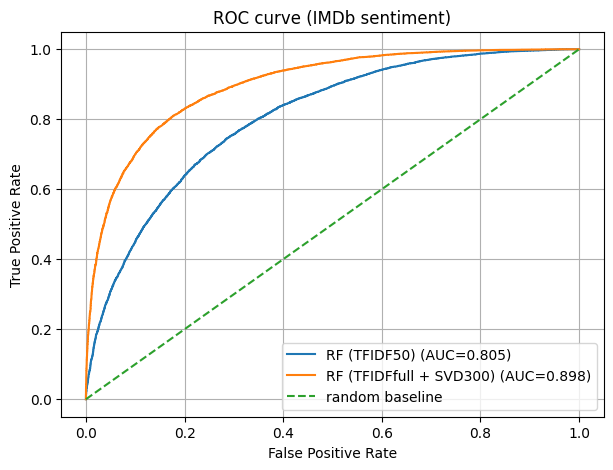

,model,test_acc,test_bal_acc,test_f1,test_roc_auc
1,RF (TFIDFfull + SVD300),0.81532,0.81532,0.812386,0.898368
0,RF (TFIDF50),0.72848,0.72848,0.737062,0.805419


In [70]:
def eval_binary_with_roc(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)

    y_pred = model.predict(Xte)
    # для ROC нужен score: probability или decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xte)[:, 1]
    else:
        y_score = model.decision_function(Xte)

    acc = accuracy_score(yte, y_pred)
    bal_acc = balanced_accuracy_score(yte, y_pred)
    f1 = f1_score(yte, y_pred)
    auc = roc_auc_score(yte, y_score)

    print(f"\n=== {name} ===")
    print(f"acc     : {acc:.4f}")
    print(f"bal_acc : {bal_acc:.4f}")
    print(f"f1      : {f1:.4f}")
    print(f"roc_auc : {auc:.4f}")
    print("confusion matrix:\n", confusion_matrix(yte, y_pred))
    print("\nclassification report:")
    print(classification_report(yte, y_pred, target_names=label_names))

    fpr, tpr, _ = roc_curve(yte, y_score)
    return {
        "model": name,
        "test_acc": acc,
        "test_bal_acc": bal_acc,
        "test_f1": f1,
        "test_roc_auc": auc,
        "fpr": fpr,
        "tpr": tpr,
    }

# -------------------------
# RF на TFIDF50 (быстро и честно)
rf_50 = RandomForestClassifier(
    n_estimators=400,
    max_features="sqrt",
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=None,
)

res_50 = eval_binary_with_roc("RF (TFIDF50)", rf_50, X_train_50, y_train, X_test_50, y_test)

# -------------------------
# RF на full TFIDF через SVD (иначе RF на 50k признаков это цирк)
rf_full = Pipeline([
    ("svd", TruncatedSVD(n_components=300, random_state=None)),
    ("rf", RandomForestClassifier(
        n_estimators=600,
        max_features="sqrt",
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=None,
    ))
])

res_full = eval_binary_with_roc("RF (TFIDFfull + SVD300)", rf_full, X_train_full, y_train, X_test_full, y_test)

# -------------------------
# ROC график (оба на одном)
plt.figure(figsize=(7, 5))
plt.plot(res_50["fpr"], res_50["tpr"], label=f'{res_50["model"]} (AUC={res_50["test_roc_auc"]:.3f})')
plt.plot(res_full["fpr"], res_full["tpr"], label=f'{res_full["model"]} (AUC={res_full["test_roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], linestyle="--", label="random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (IMDb sentiment)")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------
# Табличка итогов
final = pd.DataFrame([
    {k: v for k, v in res_50.items() if k not in ("fpr","tpr")},
    {k: v for k, v in res_full.items() if k not in ("fpr","tpr")},
]).sort_values(by="test_roc_auc", ascending=False)

final

In [10]:
from torch.utils.data import DataLoader, Dataset


In [72]:
# -------- device --------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

device: mps


In [89]:

# -------- DataLoader для CSR--------
class IdxDataset(Dataset):
    def __init__(self, n):
        self.n = int(n)
    def __len__(self):
        return self.n
    def __getitem__(self, i):
        return int(i)

def make_loader(X_csr, y, batch_size=256, shuffle=True):
    y = np.asarray(y, dtype=np.int64)

    def collate_fn(idxs):
        idxs = np.asarray(idxs, dtype=np.int64)
        # Важно: срез CSR -> плотный массив батчем (быстрее, чем по одному)
        Xb = X_csr[idxs].toarray().astype(np.float32)
        yb = y[idxs]
        return torch.from_numpy(Xb), torch.from_numpy(yb)

    return DataLoader(
        IdxDataset(X_csr.shape[0]),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,
        collate_fn=collate_fn,
        pin_memory=False,
    )

In [92]:

# -------- “однослойная” нейронка: Linear -> ReLU -> Dropout -> Linear(2) --------
# пока делал, стала двухслойной
class TwoHiddenNN(nn.Module):
    def __init__(self, input_dim, h1=256, h2=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, 2),
        )
    def forward(self, x):
        return self.net(x) 

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    loss_sum = 0.0
    correct = 0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        bs = yb.size(0)
        loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += bs

    avg_loss = loss_sum / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc

def train_nn(X_train, y_train, X_test, y_test, *,
             name="NN",
             hidden_dim=256,
             dropout=0.3,
             weight_decay=1e-4,    # L2-регуляризация
             lr=1e-3,
             batch_size=256,
             n_epochs=10):

    train_loader = make_loader(X_train, y_train, batch_size=batch_size, shuffle=True)
    test_loader  = make_loader(X_test,  y_test,  batch_size=batch_size, shuffle=False)

    model = TwoHiddenNN(input_dim=X_train.shape[1], h1=hidden_dim, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(1, n_epochs + 1):
        # ------- train -------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bs = yb.size(0)
            running_loss += loss.item() * bs
            total += bs
            correct += (logits.argmax(dim=1) == yb).sum().item()

        train_loss = running_loss / max(total, 1)
        train_acc = correct / max(total, 1)

        # ------- eval (loss+acc на тесте, без dropout) -------
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        if epoch % 10 == 0 or epoch == n_epochs or epoch == 1:
            print(
                f"{name} | Epoch {epoch}/{n_epochs} | "
                f"train_loss={train_loss:.4f} | test_loss={test_loss:.4f} | "
                f"train_acc={train_acc:.4f} | test_acc={test_acc:.4f}"
            )

    # -------- графики --------
    epochs = np.arange(1, n_epochs + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, train_losses, label="train_loss")
    plt.plot(epochs, test_losses, label="test_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{name}: loss vs epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, train_accs, label="train_acc")
    plt.plot(epochs, test_accs, label="test_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{name}: accuracy vs epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -------- финальный отчёт на тесте --------
    model.eval()
    y_pred = []
    for xb, _ in make_loader(X_test, y_test, batch_size=batch_size, shuffle=False):
        xb = xb.to(device)
        logits = model(xb)
        y_pred.append(logits.argmax(dim=1).cpu().numpy())
    y_pred = np.concatenate(y_pred)

    print(f"\n{name} TEST confusion:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["neg", "pos"]))

    return {
        "model": name,
        "test_acc": float((y_pred == np.asarray(y_test)).mean()),
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "test_accs": test_accs,
        "y_pred": y_pred,
    }

NN (TFIDF50) | Epoch 1/100 | train_loss=0.6636 | test_loss=0.5964 | train_acc=0.6424 | test_acc=0.7151
NN (TFIDF50) | Epoch 10/100 | train_loss=0.5271 | test_loss=0.5300 | train_acc=0.7373 | test_acc=0.7334
NN (TFIDF50) | Epoch 20/100 | train_loss=0.5130 | test_loss=0.5276 | train_acc=0.7473 | test_acc=0.7352
NN (TFIDF50) | Epoch 30/100 | train_loss=0.5012 | test_loss=0.5316 | train_acc=0.7568 | test_acc=0.7319
NN (TFIDF50) | Epoch 40/100 | train_loss=0.4912 | test_loss=0.5346 | train_acc=0.7638 | test_acc=0.7291
NN (TFIDF50) | Epoch 50/100 | train_loss=0.4847 | test_loss=0.5394 | train_acc=0.7680 | test_acc=0.7270
NN (TFIDF50) | Epoch 60/100 | train_loss=0.4773 | test_loss=0.5418 | train_acc=0.7693 | test_acc=0.7286
NN (TFIDF50) | Epoch 70/100 | train_loss=0.4700 | test_loss=0.5445 | train_acc=0.7747 | test_acc=0.7267
NN (TFIDF50) | Epoch 80/100 | train_loss=0.4625 | test_loss=0.5473 | train_acc=0.7802 | test_acc=0.7263
NN (TFIDF50) | Epoch 90/100 | train_loss=0.4561 | test_loss=0.550

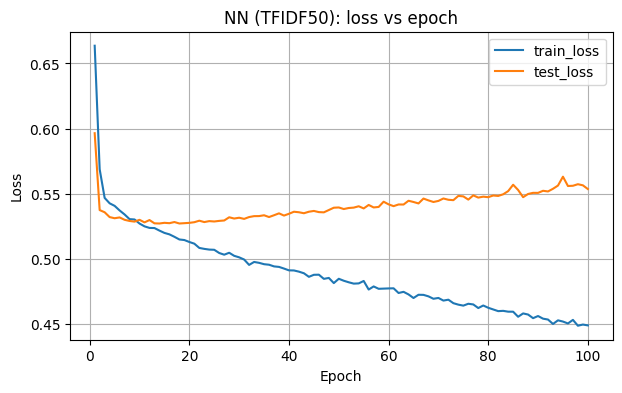

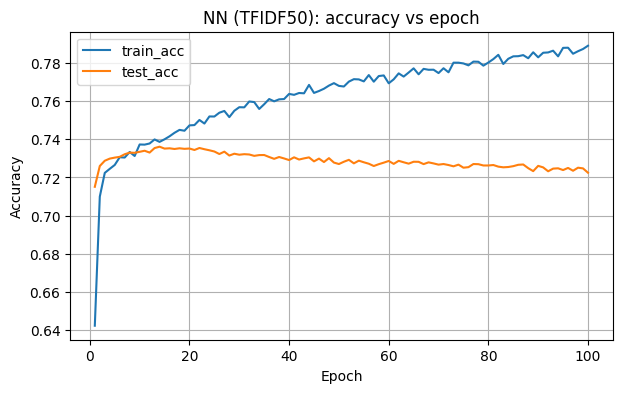


NN (TFIDF50) TEST confusion:
 [[8823 3677]
 [3261 9239]]
              precision    recall  f1-score   support

         neg       0.73      0.71      0.72     12500
         pos       0.72      0.74      0.73     12500

    accuracy                           0.72     25000
   macro avg       0.72      0.72      0.72     25000
weighted avg       0.72      0.72      0.72     25000



In [93]:

# ---------------- RUNS ----------------
# TFIDF50
res_nn_50 = train_nn(
    X_train_50, y_train, X_test_50, y_test,
    name="NN (TFIDF50)",
    hidden_dim=256, dropout=0.4,
    weight_decay=1e-4, lr=1e-3,
    batch_size=1024, n_epochs=100
)

NN (TFIDFfull=50k) | Epoch 1/50 | train_loss=0.6918 | test_loss=0.6889 | train_acc=0.5280 | test_acc=0.5503
NN (TFIDFfull=50k) | Epoch 10/50 | train_loss=0.2398 | test_loss=0.2928 | train_acc=0.9364 | test_acc=0.8943
NN (TFIDFfull=50k) | Epoch 20/50 | train_loss=0.0890 | test_loss=0.2594 | train_acc=0.9893 | test_acc=0.8926
NN (TFIDFfull=50k) | Epoch 30/50 | train_loss=0.0564 | test_loss=0.2681 | train_acc=0.9967 | test_acc=0.8885
NN (TFIDFfull=50k) | Epoch 40/50 | train_loss=0.0445 | test_loss=0.2742 | train_acc=0.9986 | test_acc=0.8870
NN (TFIDFfull=50k) | Epoch 50/50 | train_loss=0.0387 | test_loss=0.2777 | train_acc=0.9990 | test_acc=0.8872


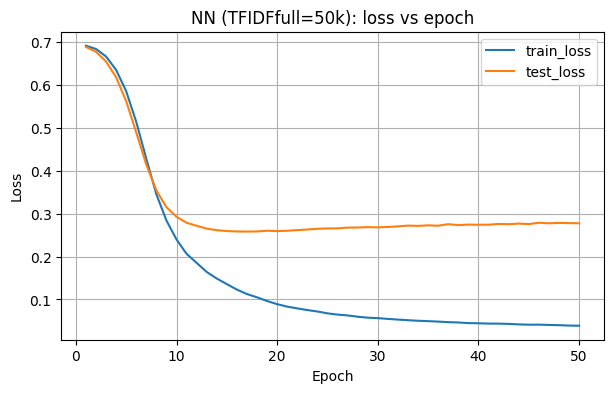

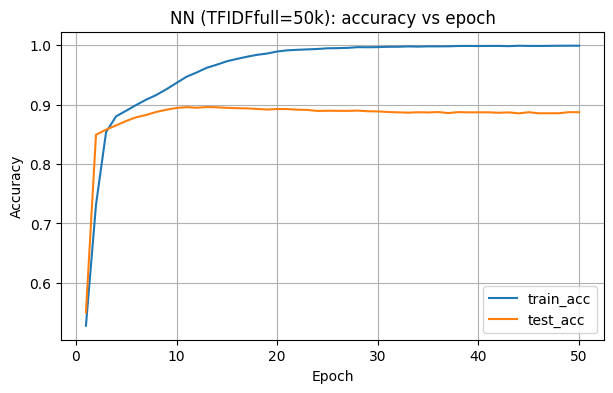


NN (TFIDFfull=50k) TEST confusion:
 [[11169  1331]
 [ 1490 11010]]
              precision    recall  f1-score   support

         neg       0.88      0.89      0.89     12500
         pos       0.89      0.88      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [94]:

# TFIDFfull (50k признаков)
res_nn_full = train_nn(
    X_train_full, y_train, X_test_full, y_test,
    name="NN (TFIDFfull=50k)",
    hidden_dim=256, dropout=0.4,
    weight_decay=1e-3, lr=3e-4,
    batch_size=2048, n_epochs=50
)

Гонял по-разному, в любому случае получаем либо переобучение, либо недообучение. Т.е. Обычные нейронки для такого не очень приспособлены, кажется. Оставил как реликвию, дальше это использоваться не будет

Возьмите готовую [BERT](https://neerc.ifmo.ru/wiki/index.php?title=BERT_(%D1%8F%D0%B7%D1%8B%D0%BA%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C))-подобную модель, из семейства [моделей](https://neptune.ai/blog/bert-and-the-transformer-architecture), которая натренирована выполнять эмоциональный анализ текста

Посмотрите, как она классифицирует несколько отзывов из датасета IMDb

In [11]:
from transformers import pipeline


In [88]:

label_names = ds["train"].features["label"].names  # ['neg','pos']

def hf_label_to_imdb_id(lbl: str) -> int:
    # pipeline обычно отдаёт 'POSITIVE'/'NEGATIVE' (SST-2),
    # но некоторые модели с хаба могут отдавать 'LABEL_0'/'LABEL_1'.
    u = lbl.upper()
    if ("POS" in u) or u.endswith("_1") or u.endswith("1"):
        return 1
    return 0

# две модели: шаблонная (SST-2) и imdb-дообученная (можно оставить одну)
bert_sst2 = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
)

bert_imdb = pipeline(
    "sentiment-analysis",
    model="textattack/bert-base-uncased-imdb",
)

# берём несколько примеров из test
N = 12
idx = np.random.choice(len(ds["test"]), size=N, replace=False)
texts = [ds["test"][i]["text"] for i in idx]
y_true = np.array([ds["test"][i]["label"] for i in idx])

# прогоняем (truncation=True важно для длинных отзывов)
out_sst2 = bert_sst2(texts, batch_size=32, truncation=True)
out_imdb = bert_imdb(texts, batch_size=32, truncation=True)

pred_sst2 = np.array([hf_label_to_imdb_id(r["label"]) for r in out_sst2])
score_sst2 = np.array([r["score"] for r in out_sst2])

pred_imdb = np.array([hf_label_to_imdb_id(r["label"]) for r in out_imdb])
score_imdb = np.array([r["score"] for r in out_imdb])

df = pd.DataFrame({
    "true": y_true,
    "true_name": [label_names[i] for i in y_true],

    "sst2_pred": pred_sst2,
    "sst2_score": score_sst2,

    "imdb_pred": pred_imdb,
    "imdb_score": score_imdb,

    "text": [t[:220].replace("\n", " ") + "..." for t in texts],
})
df["sst2_ok"] = (df["sst2_pred"] == df["true"])
df["imdb_ok"] = (df["imdb_pred"] == df["true"])

df

Device set to use mps:0
Device set to use mps:0


,true,true_name,sst2_pred,sst2_score,imdb_pred,imdb_score,text,sst2_ok,imdb_ok
0,0,neg,0,0.999702,0,0.999813,This film is an embarrassment. Nothing works o...,True,True
1,1,pos,1,0.994595,1,0.999493,"Oz was a fantastic show, as long as frequent m...",True,True
2,1,pos,1,0.999174,1,0.999828,"Hooray for Korean cinema! Last year I saw ""Chu...",True,True
3,1,pos,1,0.989386,1,0.998728,"Set in 1962 Hong Kong (in turbulent times, as ...",True,True
4,0,neg,0,0.999790,0,0.999810,This is truly one of the most awful movies of ...,True,True
5,1,pos,1,0.997502,1,0.999856,"I was expecting a lot from this movie, and I c...",True,True
6,0,neg,0,0.999794,0,0.999714,"Just to let everyone know, this is possibly th...",True,True
7,0,neg,1,0.985101,0,0.999383,The plot was really weak and confused. This is...,False,True
8,1,pos,0,0.998349,0,0.999821,I must say it was a let down. Overall its grea...,False,False
9,0,neg,0,0.999740,0,0.999841,The characters was as unoriginal it hurts. The...,True,True


Возьмите несколько понравившихся вам фильмов разных жанров и по три различных типа отзыва к ним с сайта IMDB: положительный, смешанный, отрицательный

Классифицируйте эти отзывы с помощью натренированной вами модели и с помощью готовой предтренированной модели

Сравните результаты этих двух моделей

In [12]:

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet as wn
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from transformers import pipeline

In [100]:

# ---------- препроцессинг (ровно как в пайплайне) ----------
_re_html   = re.compile(r"<[^>]+>")
_re_punct  = re.compile(r"[^\w\s]+", re.UNICODE)
_re_spaces = re.compile(r"\s+", re.UNICODE)
_re_ok     = re.compile(r"^[a-z]+$", re.IGNORECASE)

stop_set = set(stopwords.words("english"))
for w in ("not", "no", "nor", "never"):
    stop_set.discard(w)

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag: str):
    if tag.startswith("J"): return wn.ADJ
    if tag.startswith("V"): return wn.VERB
    if tag.startswith("N"): return wn.NOUN
    if tag.startswith("R"): return wn.ADV
    return wn.NOUN

def clean_text(s: str) -> str:
    s = s.lower()
    s = _re_html.sub(" ", s)
    s = _re_punct.sub(" ", s)
    s = _re_spaces.sub(" ", s).strip()
    return s

def to_lemmas_joined(text: str) -> str:
    s = clean_text(text)
    toks = word_tokenize(s)
    toks = [t for t in toks if t not in stop_set]
    tagged = pos_tag(toks)
    lemmas = [lemmatizer.lemmatize(tok, pos=penn_to_wn(tag)) for tok, tag in tagged]
    lemmas = [w for w in lemmas if _re_ok.match(w) and len(w) > 1]
    return " ".join(lemmas)

# --- BERT clean: только html + пробелы ---
_re_html = re.compile(r"<[^>]+>")
_re_spaces = re.compile(r"\s+", re.UNICODE)
def clean_for_bert(s: str) -> str:
    s = _re_html.sub(" ", s)
    s = _re_spaces.sub(" ", s).strip()
    return s

# --- label mapping ---
def hf_label_to_imdb_id(lbl: str) -> int:
    u = lbl.upper()
    if ("POS" in u) or u.endswith("_1") or u.endswith("1"):
        return 1
    return 0

def out_to_p_pos(pipe_out):
    pred = np.array([hf_label_to_imdb_id(r["label"]) for r in pipe_out])
    score = np.array([float(r["score"]) for r in pipe_out])
    p_pos = np.where(pred == 1, score, 1.0 - score)
    return pred, p_pos

# --- RF predictions---
def rf_predict_proba_texts(tfidf, rf_model, lem_joined_texts):
    X = tfidf.transform(lem_joined_texts)
    p_pos = rf_model.predict_proba(X)[:, 1]
    pred = (p_pos >= 0.5).astype(int)
    return pred, p_pos

# --- optional: mixed как "серая зона" ---
# Я брал отзывы 6/10, но учитывая, как оцениваются фильмы, то там 5/10 обычно уже негативный отзыв
def prob_to_3class(p_pos, lo=0.4, hi=0.6):
    y = np.full(len(p_pos), 1, dtype=int)   # 1=mixed
    y[p_pos <= lo] = 0                      # neg
    y[p_pos >= hi] = 2                      # pos
    return y

def label3(y3):
    return np.array(["neg", "mixed", "pos"])[y3]


In [101]:



# ---------- BERT pipeline ----------
bert = pipeline("sentiment-analysis",
                model="distilbert-base-uncased-finetuned-sst-2-english")
bert_imdb = pipeline("sentiment-analysis",
                     model="textattack/bert-base-uncased-imdb")

# ---------- 9 отзывов ----------
samples = [
    # Sci-Fi
    {"film":"Star Wars: Episode VI - Return of the Jedi", "genre":"sci-fi", "type":"positive", "text": "I'm sick of people whining about Ewoks! True, they're not the best thing that ever happened to Star Wars, but they DID happen, so deal with it! Besides, they ARE cute, and I don't care if they're marketable. Yubb Nubb! This movie always leaves me in tears. It's perfect. The end could not be better. I'm excited for The Phantom Menace because it will suddenly throw the focus of the whole story from Luke to Anakin. I love how he is revealed at the end - it would be too unresolved any other way. So those of you who are complaining that Vader's helmet was removed, take a moment to think about it. It's very effective. Vader, the man who hid behind a mask for 20 years, is finally revealed as a sick-looking man. He is not entirely machine - he's vulnerable. I don't know how the casting director happened to pick such good actors in A New Hope. They all do so well. They are believable characters. Hamill does an excellent job with his dramatic character development. Fisher does a fine job being a female role model (I mean, come on! She killed Jabba even when so many others had failed!). Harrison Ford - need I say more? The music is once again brilliant. It's so very touching and significant when you can pick out character themes at different parts of the movie. The best climax is when Luke shouts 'NOOO!' and jumps out to fight his father in the Final Battle. John Williams is nothing short of a genius! What an amazing man! Already, the movie has so much more meaning for me because of Episode I. I can't wait to finally see it in the theatres (CAN I WAIT???) and then watch the original trilogy yet again."},
    {"film":"Star Wars: Episode VI - Return of the Jedi", "genre":"sci-fi", "type":"mixed",    "text": "As a child, I owned all of the original Star Wars trilogy on VHS, purchased when 'remastering' was all the rage and the iconic sci-fi saga found itself on the receiving end of a much-needed cleaning-up. This was, however, before George Lucas tampered with his already- near-perfect legacy, adding unneeded special effects and elongating certain scenes for seemingly no other reason to show how far CGI had come (although it now looks incredibly dated). Despite the perfection of episodes four and five, my go-to Star Wars movie on a boring Sunday afternoon was always Return of the Jedi, the third instalment now widely remembered as the poorest of the bunch. I don't quite know what it was about Jedi that always caused me to reach for it. It certainly wasn't the Ewoks, those cuddly fur-balls shoe-horned in to sell more merchandise, although they aren't as annoying or distracting as I remembered. Jedi is most certainly the least effective of Lucas' creation, but there's still plenty of charm and excitement to solidify the entry as, at the very least, a satisfying closure to the saga, despite Disney's welcome efforts to further explore the Star Wars universe. The Empire Strikes Back broke up its characters but managed to keep a firm grasp on the various story-threads. Jedi does the same again, but is less successful at holding all the action together. Nevertheless, the characters get to enjoy an early reunion at Jabba the Hutt's palace on Tatooine, where the slug-like abomination hangs Han Solo (Harrison Ford), still frozen in his carbonite prison from the last movie. C- 3PO (Anthony Daniels), R2-D2 (Kenny Baker), Chewbacca (Peter Mayhew) and Lando Calrissian (Billy Dee Williams) all arrive at various intervals as part of a rescue operation, as does Princess Leia (Carrie Fisher) and Luke Skywalker (Mark Hamill), the latter having completed his Jedi training and going about his business with a brooding confidence. A horrific car crash may have robbed Hamill of some of his boyish good-looks, but it did nothing to dampen his skills as an actor. Skywalker's newly-found intensity, which no doubt stems from his flourishing grasp on the Force and skill with a lightsaber, is matched by Hamill's execution. He stops by to see Yoda (Frank Oz), who confirms that Darth Vader is indeed his father and a fallen Jedi, and has a brief chat with the spirit of his mentor Obi-Wan Kenobi (Alec Guinness). Skywalker's thread is by far the most interesting, inevitably heading towards a showdown with his father and the puppet-master behind the Empire, the rasping Emperor (Ian McDiarmid). Although Vader's brutality has been turned down as he plays lap-dog to his boss, audiences back in 1983 must have been holding their breath as the Emperor tortures Luke in an attempt to turn him to the Dark Side, and Vader is clearly shown to be wrestling with his allegiance. The rest of the action fares less well, as Han Solo and Leia find themselves captured by the community of Ewoks who seem to want to eat them, while C-3PO bares a close resemblance to the God the little critters worship. Their aim is to take down a generator controlling the energy shield of a brand new Death Star - yes, they have somehow managed to nearly complete a bigger, meaner planet- killer in a remarkably short space of time. Lando and the remaining Rebel Alliance are forced to repeat the climax of A New Hope, and while it's certainly a spectacular battle, it can't help but feel like more of the same. Jedi is best remembered as a series of memorable moments than a truly great film. It's easy to forget the film's messy narrative and cynical desire to boost merchandise sales, especially as a child, but it's hard to forget Leia in a gold bikini, Jabba's grotesque rat-like pet, the high-speed chase through the forests of Endor, or the shockingly crap death of fan-favourite Boba Fett. Nowhere near the annoying child-pandering misfire some believe it to be, but also some way off the magnificence of its predecessors."},
    {"film":"Star Wars: Episode VI - Return of the Jedi", "genre":"sci-fi", "type":"negative", "text": "The STAR WARS films are a hallmark of our culture. Everyone who wants to study film should see them, because they display quite accurately how not to make a movie, and in particular how not to write a script. I cannot even express how much is wrong is these movies, in every possible respect. Obviously they are cynically manufactured with money in mind (Ewoks!? C'mon!), and obviously they wrecked the notion of film as anything but lightweight, even dull and stupid, entertainment. What even some of the series' detractors fail to see is how awful the movies would be with or without the hype. Let's start with the acting. I can't believe anyone ever took Mark Hamill seriously; meanwhile, Harrison Ford's attempts at emotion are downright laughable. Carrie Fisher does what she can, but like everyone else, she's saddled with some unspeakable dialogue. Far more offensive is the storyline that runs through the three films (and presumably the three prequels as well). You tell me with a straight face that no loser thirteen year-old who reads sci-fi comics couldn't come up with this tripe, and I will applaud you. George Lucas has created a masturbatory set of films in a remarkably self-indulgent attempt to take advantage of the notoriety he achieved with AMERICAN GRAFFITI. Let's not beat around the bush, these movies have one of the dumbest plots ever transferred to celluloid. 'The Force'? Wow, talk about covering your tracks... to try to avoid plot holes, Lucas creates this invisible dimension that can let people do anything, like pick up out-of-reach objects (as seen in the remarkable 'Luke retrieves a Kenner toy which you could go buy right now from the snow while he hangs upside down' scene, the stuff of great cinema, in the second film). How exciting. I'd like to have a Force in my house so I won't have to get up to change the TV channel when this idiotic movie comes on. The script? Don't even get me started. To be frank, what little plot there is doesn't make much sense. And talk about episodic! It's just one toy commercial after another, from the completely pointless 'speeder-bike' scene to the seemingly endless chunk of partying from the Care Bears or whatever those things were. Any fan page or even the IMDB will hold a nice collection of ludicrous quotes, and the fans will probably shiver with glee, while I sit and gawk at how a screenplay with no trace of talent to be found can gain the respect of millions. Most offensively, you've got a score that screams and manipulates like a sitcom laugh track or a Nazi anthem (but then, John Williams never offered anything but recycled schmaltz to start with). In essence, I remain fascinated by the fact that more people have seen this than will sit through the infinite number of films that have more imagination and emotion in a single second than the entire 'Star Wars' series can muster. The worst part is, if you issue any kind of a dissenting opinion on this boring junk, a million raging fanboys will assault you for not showing the proper degree of worship to a supposed American classic. Jonathan Rosenbaum said in 1997 that destroying every print of the Star Wars films wouldn't solve any of the problems caused by them, but that he wouldn't shed a tear at the loss. I would agree. I don't claim to have any authority over anyone's love of the series, and if you genuinely love these films, that's great. I just don't understand why those who disagree are so frequently labeled 'flamers.' I apologize for not wanting my brain to turn to mush. My rating: 0/10"},

    # Fantasy
    {"film":"The Lord of the Rings: The Fellowship of the Ring", "genre":"fantasy", "type":"positive", "text": "The first part of the Lord of the Rings trilogy, the Fellowship of the Rings opened the door to a whole new world for me. I'd never read any of Tolkien's books when I saw the film for the first time at the theatre and, now that I've read them, in retrospect I think being a neophyte to the mythology made my LOTR movie experience all the more miraculous. I loved The Two Towers and Return of the King almost as much as FOTR, but not quite, because seeing Fellowship for the first time was like taking a journey to a fabulous new place and meeting incredible new friends that you don't want to leave. I've never felt anything quite like what this epic evoked in me. It was akin to being a child again, with that tireless sense of wonder and enjoyment of each and every moment, maybe because as a child you are discovering your surroundings, and whatever age you are, when you watch the Fellowship of the Ring you are rendered in awe upon being introduced to the purity and beauty of Middle Earth and darkly enthralled by the majesty of Eisengard, Saruman, Sauron and all of their mighty malice. One of the things that makes this movie so special (and there are so many!) is that you fall in love not only with the 'good' characters, but also with the 'evil' ones. For example, Christopher Lee was amazing as Saruman, and I can't imagine the movie without him. Some films that might be comparable to the Lord of the Rings trilogy are: The Fifth Element, the Star Wars Trilogy parts IV, V and VI (forget the newer prequels), the Matrix trilogy (especially the first part), Interview with a Vampire, the Legend of Sleepy Hollow (with Johnny Depp), Logan's Run and The Island. They are all excellent movies and works of art that weave that movie magic that keeps you spellbound and entranced for the duration of their runtime. But after seeing The Fellowship of the Ring, I knew I had found the movie by which I would judge all other movies. Based on J.R.R. Tolkien's beloved books, Peter Jackson has set a new standard in the industry of cinema, one that I honestly think has not and won't be surpassed, at least not in my lifetime, not even by PJ himself. It is truly an instant classic that will stand the test of time and be loved by generations to come. God Bless Tolkien and Jackson and everyone involved in the conception and making of this film, for creating a world that is at my fingertips, only takes the touch of a button to go to whenever I want, and makes me forget everything else. The LOTR Trilogy is undoubtedly MY precious, the non plus ultra of all movies!"},
    {"film":"The Lord of the Rings: The Fellowship of the Ring", "genre":"fantasy", "type":"mixed",    "text": "Tracking all the making of information leading up to the film, it seemed like Jackson was doing a great job. The scenery, props, casting, makeup, and effects all seemed beautifully authentic. And in action, they deliver. But the script (it's always a danger when you see three writers and one of them is the director) spoils the magic. It's more than making Arwen's role more significant (and a completely different character) in a blatant attempt to beef up the roles for women. I didn't like that, but women's roles are admittedly sadly lacking in the original story. It's that Jackson puts his clumsy fingerprints all over Tolkien's themes and tells the story from the perspective of Men. Apparently, modern moviegoers need to identify with their race. (Side note: all the critics who say how the movie has preserved the magic of the books probably haven't read them since college.) The relationship between the four hobbits isn't set up at all in the movie; aside from Frodo the other three hobbits seem thrown into the quest by chance. Rather than being a reluctant, conflicted hero, Frodo is praised by all the other characters but actually does little but squeal, get stabbed, and look on the elves in wonder. Saruman (a lesser character in the fiction who only appears the first book through Gandalf's recollection) takes up far too much time in the movie. And by the end we've seen Sauron's eye so much I wonder there's anything to reveal of the dark lord in the second and third movies. I expected changes, but I fail to see the rationale for many of Jackson's edits--they don't make the story better or the action flow more smoothly. The Lord of the Rings is an elegiac tale of the passing of magic from the world and of the heroic struggles of those races passing from the world to preserve goodness. In Jackson's eyes, history is told from the perspective of the victors, the Men. Hobbits, who drive the action in the books, are along for the ride while Aragorn, Boromir, et al are the real protagonists in the movie. I give Jackson full credit for taking on a task of this scale and achieving an epic feel. If only he'd started with a script as good as his scenery."},
    {"film":"The Lord of the Rings: The Fellowship of the Ring", "genre":"fantasy", "type":"negative", "text": "I am assuredly in the minority when I state Jackson's Lord of the Rings Trilogy is some of the worst film making I have ever seen. It would appear that he and his production team read the books, sort of, maybe 30 years ago; bought the Cliff notes, and from that wrote the screenplay. To illustrate my POV, I recommend listening to the superlative 13 hour radio adaptation produced by the BBC, recorded I believe in 1981. Jackson and crew erred when they depended too much on computer fx, and spent too much time on the spectacle of combat and war. I often thought I was watching a slasher movie. What makes the original Trilogy compelling are the relationships and the subtext characters carry with them from beginning to end. To be sure there are mythic battles, both large and small. But they come out of very carefully crafted relationships and a deep well of subtext. I don't quarrel with the New Zealand locations, I do quarrel with the dumpy looking sets that were haphazardly glossed over with computer grafx fixes. I don't quarrel with the casting except Frodo, and yet I found the direction so superficial, and often perplexing, if not simply muddled (Galadriel as an English Vamp?!). A clue to my dissatisfaction can be found in the omission of Tom Bombadil, the only character in the original not affected by the Ring. His eccentric wisdom and unexplained powers ground the plot because there is something, someone who is outside the Dark Lord's power. There is in the Tolkien universe a power unimaginable which Sauron cannot touch. And that is essential to the fabric which holds Middle Earth together. Which Tolkien in his craft and his wisdom knew he had to give expression to. And Jackson in his foolhardiness ignored. Why didn't Jackson's team follow the books with more trust? The master had already worked it out perfectly. Well, almost. The Trilogy wasn't long enough, which Tolkien realized after its completion. Nevertheless, the project would have been immensely improved had Jackson and his team laid out a six episode franchise to match the six books of the Trilogy, taken more time to film it in their excellent locations of choice, and above all, truly paid homage to its original creator by following his work faithfully. These films are a mish-mash which titillated the masses for a brief time. And that is tragic, because it will be long, long before someone will be able to do them justice."},

    # military
    {"film":"Apocalypse Now", "genre":"military", "type":"positive", "text": "My favourite movie of all time. This was a flawed piece of work by Coppola and seeing the documentary 'Heart of Darkness' made it even more compelling. Coppola at this point was king of Hollywood after making 'the Godfather' and 'GodfatherII' and had developed the ego necessary to even dare try to make a movie like 'Apocalypse Now'. Through sheer arrogance he went to the Phillipines with a partial script and thought he would know what he would do when he got there. Just as Captain Willard thought he would know what to do once he got to Col. Kurtz's compound. And just like Willard, he DIDN'T know what he was going to do once he got there. This is such a masterpiece of American cinema, beautifully photographed and the river is such a perfect metaphor and backdrop for the story. What I like most about 'Apocalypse Now' is that it offers no answers or conclusions. Consequently, because of this open-endedness, it infuriates some viewers who like their movies to be much more obvious. This movie defies categorization. Some call it a war movie which it isn't at all, really it is more of a personal study of man. The best pic about Vietnam is 'Platoon' in my opinion and if a viewer is seeking a retelling of the Vietnam War go there first for answers. Coppola should be commended for his take on the bureaucracy of war which he conveys quite effectively with the meeting with Gen.Corman and Lucas (Harrison Ford) and the Playmate review. The sheer audacity of Kilgore makes him an unforgettable character and the dawn attack will always be a Hollywood classic. It is an almost psychedelic cruise to a very surreal ending which makes it a movie not accessible to everyone. Very challenging to watch but rewarding as well. I could offer my explanations on each scene but that would be totally pointless. This movie is intended for interpretation and contemplation as opposed to immediate gratification. A little footnote, definitely if your a first-time viewer of Apocalypse Now, watch the original version first, the 'Redux' version is, I think, more intended for the hardcore fan and is more of a curiosity than a 'new and improved' version of the movie"},
    {"film":"Apocalypse Now", "genre":"military", "type":"mixed",    "text": "Now, believe it or not, but I have actually never seen the 1979 movie 'Apocalypse Now' before now in 2023. Yeah, I know, a mistake on my account. But I just never gotten around to sitting down to watch it. Of course I was familiar with the movie, but the movie's cover just never really appealed to me enough to make me give it a go. But as I had the chance to sit down and watch the movie here in 2023, of course I did so. And I have been curious to see if the movie is as good as I have been told. Writers John Milius and Francis Ford Coppola put together an entertaining script and storyline for the movie. And I have to say that I was adequately and genuinely entertained by the movie. Well, right up to the point where Captain Willard (played by Martin Sheen) got to the camp in Cambodia where Colonel Kurtz (played by Marlon Brando) was waiting. The movie sort of lost its momentum there and changed direction quite dramatically, and not in a sense that appealed much to me. Something that really impressed me about the movie was the cast ensemble, because they had a lot of amazing talents on the cast list, with the likes of Martin Sheen, Marlon Brando, Robert Duvall, Laurence Fishbourne, Dennis Hopper, Scott Glenn, Harrison Ford and others. 'Apocalypse Now' looked and felt like a Vietnam War movie, although quite a different approach to making such a movie from director Francis Ford Coppola. But it was definitely an interesting take on the subject, and it made for a watchable and enjoyable movie.The downside to this 1979 movie was the length. Running at nearly 180 minutes, it was a tad too long in my opinion, and could have benefitted from either a trim or more added action."},
    {"film":"Apocalypse Now", "genre":"military", "type":"negative", "text": "In my opinion, most fans don't realize that this 'Vietnam War' movie was conceptually based on an 1899 book called Heart of Darkness by Joseph Conrad. The book depicts the ivory trade in Africa and is set in the Belgian Congo. The story follows a sailor traveling upriver to find an ivory trader named Kurtz, who is ill and being worshiped by the natives. To me, it seems like the writers added the Vietnam War theme to make it more marketable. Many reviews, in my view, are shallow-they treat this chaotic movie like it's some kind of profound documentary on Vietnam. Critics praise it as a 'masterpiece,' but to me, it feels more like a disjointed, overhyped spectacle. Rather than offering real insight, I think it glorifies immature, reckless behavior, almost like it was made for people who equate chaos and destruction with power or strength. After the success of The Godfather, the next step seemed to be cashing in on another hit. What could be better than a movie packed with war, gratuitous violence, explosions, playboy bunnies, and rock and roll? To me, it feels like a fantasy tailor-made for audiences who want to believe this kind of behavior is cool or heroic. The production, in my opinion, was just as chaotic. On the set in the Philippines, the crew rented helicopters from a corrupt government, blew up anything they could, and even filmed the real killing of a water buffalo for shock value. To me, this choice was unnecessary and exploitative. While some argue the film is an anti-war statement, I find it hard to believe when so much gratuitous violence was used just to make it. As you can tell, I didn't like this movie. To me, it felt like a shallow excuse to show destruction and violence while pretending to be profound. The characters, in my view, acted like emotional teenagers with no depth, and the story seemed to revel in chaos. I think this movie appeals to the base immaturity of some viewers who want to believe this style of behavior is powerful or admirable, but to me, it's nothing more than a chaotic and empty fantasy."},
]


raw_texts = [s["text"] for s in samples]
lem_texts = [to_lemmas_joined(t) for t in raw_texts]   # для RF
bert_texts = [clean_for_bert(t) for t in raw_texts]    # для BERT

pred50, proba50 = rf_predict_proba_texts(tfidf50, rf_50, lem_texts)
predfull, probafull = rf_predict_proba_texts(tfidf_full, rf_full, lem_texts)

bert_out = bert(bert_texts, batch_size=16, truncation=True)
bert_pred, bert_p_pos = out_to_p_pos(bert_out)

bert_imdb_out = bert_imdb(bert_texts, batch_size=16, truncation=True)
bert_imdb_pred, bert_imdb_p_pos = out_to_p_pos(bert_imdb_out)



df_cmp = pd.DataFrame(samples)

df_cmp["RF50_p(pos)"] = np.round(proba50, 4)
df_cmp["RF50_3"]      = label3(prob_to_3class(proba50))

df_cmp["RFfull_p(pos)"] = np.round(probafull, 4)
df_cmp["RFfull_3"]      = label3(prob_to_3class(probafull))

df_cmp["BERT_p(pos)"] = np.round(bert_p_pos, 4)
df_cmp["BERT_3"]      = label3(prob_to_3class(bert_p_pos))

df_cmp["BERT_imdb_p(pos)"] = np.round(bert_imdb_p_pos, 4)
df_cmp["BERT_imdb_3"]      = label3(prob_to_3class(bert_imdb_p_pos))

df_cmp[["genre","film","type",
        "RF50_3","RF50_p(pos)",
        "RFfull_3","RFfull_p(pos)",
        "BERT_3","BERT_p(pos)",
        "BERT_imdb_3","BERT_imdb_p(pos)"]]




Device set to use mps:0
Device set to use mps:0


,genre,film,type,RF50_3,RF50_p(pos),RFfull_3,RFfull_p(pos),BERT_3,BERT_p(pos),BERT_imdb_3,BERT_imdb_p(pos)
0,sci-fi,Star Wars: Episode VI - Return of the Jedi,positive,pos,0.7244,pos,0.7224,pos,0.9997,pos,0.9998
1,sci-fi,Star Wars: Episode VI - Return of the Jedi,mixed,mixed,0.5899,pos,0.6842,pos,0.9753,pos,0.9997
2,sci-fi,Star Wars: Episode VI - Return of the Jedi,negative,mixed,0.4241,neg,0.2804,neg,0.0006,neg,0.0002
3,fantasy,The Lord of the Rings: The Fellowship of the Ring,positive,pos,0.6771,pos,0.6096,pos,0.9996,pos,0.9998
4,fantasy,The Lord of the Rings: The Fellowship of the Ring,mixed,pos,0.6184,mixed,0.5333,neg,0.0385,neg,0.0004
5,fantasy,The Lord of the Rings: The Fellowship of the Ring,negative,neg,0.3558,mixed,0.4651,neg,0.0081,neg,0.0002
6,military,Apocalypse Now,positive,neg,0.2331,mixed,0.5164,neg,0.2943,pos,0.9998
7,military,Apocalypse Now,mixed,mixed,0.4378,mixed,0.4587,pos,0.9260,pos,0.9929
8,military,Apocalypse Now,negative,mixed,0.4222,mixed,0.4196,neg,0.0010,neg,0.0002


**Вопрос:** Совпадает ли эмоциональная оценка отзывов двумя этими моделями? Какая модель справилась лучше?

Ну, тот факт, что BERT прям уверенно определила положительный отзыв в негативный – это странно. При этом смешанный закинула в положительные... Итого, получается, что RF, обученный на 50к фичей оказался более правильным с точки зрения бинарной оценки... Хотя тут слишком малая выборка для этого, как по мне.

Нейронки участия не принимали, мне не понравилось, как они обучились, так что они просто существуют

## Задача 4

Другой полезной и интересной задачей является генерация текста. Идея состоит в том, чтобы на основе некоторого запроса, контекста и предыдущих слов ответа сгенерировать следующее слово. Такая задача достаточно успешно решена с помощью Генеративных Предобученных Трансформеров (GPT)

Отдельно про трансформеры можно говорить долго, основная статья, в которой они впервые появились [*Attention Is All You Need*](https://arxiv.org/abs/1706.03762)

Основной техникой в глубоком обучении, позволяющей решать свои задачи на основе уже существующих предобученных моделей является *Fine Tuning* (Дообучение). Идея в том, что модель уже выучила какие то представления из данных, у неё уже достаточно хорошо подобранные веса, и необходимо только немного их подкорректировать под данные нашей задачи

Загрузите модель *sberbank-ai/rugpt2-small* и токенайзер слов для неё из модуля *transformers* с помощью методов *GPT2LMHeadModel, GPT2TokenizerFast*

In [13]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [28]:

MODEL = "ai-forever/rugpt3small_based_on_gpt2"  # публичный ruGPT, GPT-2-стиля, сберовская нейронка недоступна без авторизации

tok = GPT2TokenizerFast.from_pretrained(MODEL)
model = GPT2LMHeadModel.from_pretrained(MODEL)

tok.pad_token = tok.eos_token
model.config.pad_token_id = tok.eos_token_id

device = "mps" if torch.backends.mps.is_available() else "cpu"
model.to(device)

prompt = "Другой полезной и интересной задачей является генерация текста, потому что"
x = tok(prompt, return_tensors="pt").to(device)

y = model.generate(
    **x,
    max_new_tokens=80,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    repetition_penalty=1.1,
)

print(tok.decode(y[0], skip_special_tokens=True))

Другой полезной и интересной задачей является генерация текста, потому что она может быть полезна в различных областях. 

 На сайте представлены статьи, обзоры книг, статей по психологии, психологии детей, а так же подборка советов психологов для родителей.  Вы можете задавать вопросы о книгах или статьях на форуме.  Все статьи, представленные на сайте, написаны нашими авторами и защищены авторским правом. 
 Здравствуйте!  Я как-то попала на курсы психолога.


Если поставить температуру 0.9, то она начинает генерировать практически HTML-страницу. Те, кто её обучали явно не учли этот момент

Найдите и загрузите понравившийся вам текст на русском языке с несколькими сотнями/тысячами предложений

In [15]:
from ebooklib import epub
from ebooklib.epub import EpubHtml
from bs4 import BeautifulSoup

def epub_to_txt(epub_path: str, out_path: str):
    book = epub.read_epub(epub_path)
    chunks = []

    for item in book.get_items():
        if isinstance(item, EpubHtml):
            soup = BeautifulSoup(item.get_content(), "lxml")
            text = soup.get_text("\n")
            chunks.append(text)

    txt = "\n".join(chunks)
    txt = re.sub(r"\n{3,}", "\n\n", txt).strip()

    with open(out_path, "w", encoding="utf-8") as f:
        f.write(txt)

def keep_cyrillic_lines(text: str, thr: float = 0.35) -> str:
    out = []
    for line in text.splitlines():
        letters = re.findall(r"[A-Za-zА-Яа-яЁё]", line)
        if not letters:
            continue
        cyr = re.findall(r"[А-Яа-яЁё]", line)
        if len(cyr) / len(letters) >= thr:
            out.append(line)
    return "\n".join(out)

epub_to_txt("lev_nikolaevich_tolstoj_vojna_i_.epub", "book_raw.txt")

with open("book_raw.txt", "r", encoding="utf-8") as f:
    t = f.read()

t2 = keep_cyrillic_lines(t, thr=0.35)

with open("book.txt", "w", encoding="utf-8") as f:
    f.write(t2)

print("OK:", len(t2), "chars")
print("n-sentences:", len(t2)/(6.1*12.5))

/var/folders/d4/pdhkc1y53l5bywltpcg3j0cm0000gp/T/ipykernel_19414/2984309604.py:11: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(item.get_content(), "lxml")


OK: 2907455 chars
n-sentences: 38130.55737704918


Токенизируйте текст с помощью загруженного токенайзера

In [16]:
with open("book.txt", "r", encoding="utf-8") as f:
    text = f.read()

# минимальная чистка пробелов 
text = re.sub(r"\s+", " ", text).strip()

# токенизируем в 1 длинную последовательность id
ids = tok.encode(text, add_special_tokens=False)
ids.append(tok.eos_token_id)  # чтобы явно завершить поток

print("n_tokens =", len(ids))
print("first 200 tokens decoded:\n", tok.decode(ids[:200]))

Token indices sequence length is longer than the specified maximum sequence length for this model (684698 > 2048). Running this sequence through the model will result in indexing errors


n_tokens = 684699
first 200 tokens decoded:
 Стрелки 86-го, вперед! серьезно. Вы собираетесь на войну, князь? Когда будет нужно, вас позовут. – Бывает с тобой, – сказала Наташа брату, когда они уселись в диванной, – бывает с тобой, что тебе кажется, что ничего не будет – ничего; что все, что хорошее, то было? И не то что скучно, а грустно? – Еще как! – сказал он. – У меня бывало, что все хорошо, все веселы, а мне придет в голову, что все это уж надоело и что умирать всем надо. Я раз в полку не пошел на гулянье, а там играла музыка… и так мне вдруг скучно стало… – Ах, я это знаю. Знаю, знаю, – подхватила Наташа. – Я еще маленькая была, так со мной это было. Помнишь, раз меня за сливы наказали, и вы все танцевали, а я сидела в классной и рыдала. Так рыдала, никогда не забуду. Мне


In [17]:
block_size = 1024  # Для GPT-2 <= 1024, ставлю максимум просто потому что могу)

n = (len(ids) // block_size) * block_size
ids_cut = ids[:n]

input_ids = torch.tensor(ids_cut, dtype=torch.long).view(-1, block_size)
labels = input_ids.clone()  # для GPT2LMHeadModel это ок: он сам сдвигает внутри

print("batches x block_size =", input_ids.shape)

batches x block_size = torch.Size([668, 1024])


Дообучите GPT2 на вашем тексте с помощью класса *transformers.Trainer*

In [18]:
import os
import math
from transformers import (
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

In [19]:
# чтобы влезало в память и не было лишних буферов
model.gradient_checkpointing_enable()
model.config.use_cache = False

In [20]:
from torch.utils.data import Dataset

class LMBlocks(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, i):
        return {
            "input_ids": self.input_ids[i],
            "labels": self.labels[i],
        }

# простой split: последние 1% блоков оставим под eval
n_total = input_ids.size(0)
n_val = max(1, int(0.01 * n_total))

train_ds = LMBlocks(input_ids[:-n_val], labels[:-n_val])
eval_ds  = LMBlocks(input_ids[-n_val:], labels[-n_val:])

print("train blocks:", len(train_ds), "eval blocks:", len(eval_ds))

train blocks: 662 eval blocks: 6


In [21]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tok, mlm=False)

In [25]:
out_dir = "rugpt3small_warpeace_ft"

args = TrainingArguments(
    output_dir=out_dir,
    overwrite_output_dir=True,

    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,  # “виртуальный” батч побольше

    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=100,

    num_train_epochs=10,             # сначала была одна эпоха, потом расширил до 10. на M1pro скорость примерно 7-8 min/epoch
    eval_strategy="steps",
    eval_steps=200,
    save_steps=200,
    save_total_limit=2,

    logging_steps=20,
    report_to="none",

    fp16=False,
    bf16=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tok,
    data_collator=data_collator,
)

trainer.train()

trainer.save_model(out_dir)
tok.save_pretrained(out_dir)
print("saved to:", out_dir)

/var/folders/d4/pdhkc1y53l5bywltpcg3j0cm0000gp/T/ipykernel_19414/290721958.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/zuha/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
200,3.129500,3.286395
400,2.959200,3.288944
600,2.781100,3.322425
800,2.757100,3.333184


/Users/zuha/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/zuha/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/zuha/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


saved to: rugpt3small_warpeace_ft


Сгенерируйте несколько предложений с помощью дообученой модели и её метода *generate*

In [26]:
model.config.use_cache = True  # обратно можно вернуть

ft_tok = GPT2TokenizerFast.from_pretrained(out_dir)
ft_model = GPT2LMHeadModel.from_pretrained(out_dir).to(device)
ft_model.config.pad_token_id = ft_tok.eos_token_id
ft_model.config.use_cache = True
ft_model.eval()

prompt = "Другой полезной и интересной задачей является генерация текста, потому что"
x = ft_tok(prompt, return_tensors="pt").to(device)

with torch.no_grad():
    y = ft_model.generate(
        **x,
        max_new_tokens=80,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.1,
    )
print(ft_tok.decode(y[0], skip_special_tokens=True))

Другой полезной и интересной задачей является генерация текста, потому что она есть орудие для достижения цели. От того же зависит, насколько хорошо будет передана цель. В отношении средств, которыми пользуется человек, то цель его жизни состоит в том, чтобы быть счастливым; но цель эта не может быть достигнута, если она не совпадает с планом, по которому должна идти жизнь человека. Для того чтобы достигнуть цели, человек должен иметь власть над другими людьми и тем самым постоянно пользоваться ею.


Попросите продукт [ChatGPT](https://chatgpt.com/) компании OpenAI или любую другую доступную GPT-подобную модель сгенерировать несколько предложений в стиле вашего текста. Сравните ответы двух моделей между собой

In [ ]:
# ответ ChatGPT
"""Другой полезной и интересной задачей является генерация текста, потому что она проверяет сразу несколько вещей, которые людям обычно нравится считать “магией”.

Генерация текста полезна, потому что заставляет модель понимать структуру языка, контекст, причинно-следственные связи и намерения автора, а не просто подбирать слова по частоте. Если система может связно продолжать мысль, удерживать тему и стиль, значит она хоть как-то разобралась, что вообще происходит в тексте, а не просто притворяется словарём с моторчиком.

Интересна она по той же причине, по которой люди любят смотреть на говорящих попугаев, только здесь попугай ещё и иногда попадает в смысл. Текст — универсальный интерфейс для знаний, инструкций, идей и заблуждений, поэтому умение его генерировать автоматически сразу открывает кучу применений: от помощи в программировании до анализа данных и обучения.

И да, это ещё и отличный способ наглядно увидеть границы системы. Как только тема уходит в сложную логику или проверяемые факты, иллюзия “понимания” начинает трещать. Что, если честно, полезнее, чем очередная демка, где всё выглядит слишком хорошо, чтобы быть правдой."""

**Вопрос:** Получились ли ответы трансформеров реалистичными? Какая модель справилась лучше с генерацией текста?

Итого: чистая модель явно была обучена просто на статьях из интернета, соответственно она туда и скатилась. Немного дообученная на Войне и Мире выдала очень даже связный текст, но там достаточно много повторений и она явно растекается мыслею по древу, как это любит делать Толстой. GPT-5.2 же – совершенно другой случай, тк если её не останавливать, то она и нормальный рассказ написать может) 